In [42]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping



# Download data

In [3]:
# Download the data

# Define the path to the JSON file
file_path = '/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/shipsnet.json'

# Open and load the JSON file into a dictionary
with open(file_path, 'r') as file:
    data = json.load(file)


# Exploring data

In [4]:
data.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [5]:
image_data = data['data']


print(type(image_data))
print(len(image_data))

<class 'list'>
4000


In [6]:
labels = data['labels']



print(type(labels))
print(len(labels))
print(labels)

<class 'list'>
4000
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [7]:
location_data = data['locations']

print(type(location_data))
print(len(location_data))
print(location_data)

<class 'list'>
4000
[[-118.2254694333423, 33.73803725920789], [-122.33222866289329, 37.7491755586813], [-118.14283073363218, 33.736016066914175], [-122.34784341495181, 37.76648707436548], [-122.34852408322172, 37.75878462398653], [-118.16932888763621, 33.734252827962536], [-122.35145112805893, 37.75120269950231], [-122.35158678931549, 37.74736384875284], [-122.34695357410399, 37.73984834452207], [-122.34291347769646, 37.75007383360081], [-122.3360897908182, 37.72864739533354], [-122.3287178577925, 37.73823169303052], [-122.32579167236734, 37.72675026209499], [-122.34943264991506, 37.7405921187298], [-122.34681533273329, 37.759451149806985], [-122.3359293751746, 37.7580383438423], [-118.14847605898571, 33.72708936752747], [-122.36586298001781, 37.762367278018836], [-122.32249779505129, 37.725839074693205], [-122.34205451391247, 37.75093430235835], [-118.15349753221352, 33.69822802602944], [-122.32256994909217, 37.717916915564196], [-122.33374787980998, 37.720251935906376], [-118.2155086

In [8]:
scene_ids = data['scene_ids']

print(type(scene_ids))
print(len(scene_ids))
print(scene_ids)

<class 'list'>
4000
['20180708_180909_0f47', '20170705_180816_103e', '20180712_211331_0f06', '20170609_180756_103a', '20170515_180653_1007', '20171022_175534_100e', '20171129_181545_1022', '20170508_180611_1010', '20170703_180945_1009', '20171212_181755_0e26', '20170106_180851_0e30', '20180705_213444_0f02', '20170723_180812_1005', '20180209_184353_0f21', '20180708_182358_1032', '20170903_181304_1041', '20180131_175841_1010', '20180205_181811_1030', '20170622_180819_1034', '20170616_180825_100e', '20171025_175648_0e26', '20170613_180813_1017', '20171210_181628_100a', '20180710_180333_1002', '20180312_182016_1042', '20171129_181545_1022', '20180708_180453_0f28', '20170622_180818_1034', '20170905_181214_0f12', '20170709_181332_0e0e', '20180708_180908_0f47', '20170717_180818_1010', '20170505_181258_0e2f', '20180708_182359_1032', '20170622_180819_1034', '20170613_180813_1017', '20170702_181120_103a', '20161011_185736_0c72', '20170515_180653_1007', '20180206_181845_0f34', '20180711_182156_10

## Deep dive image data

In [9]:
print(image_data[1])

[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 69, 75, 72, 71, 70, 68, 69, 76, 82, 84, 83, 77, 76, 78, 85, 87, 83, 75, 67, 64, 67, 65, 65, 70, 69, 56, 55, 58, 61, 68, 67, 65, 68, 70, 72, 71, 72, 76, 75, 76, 84, 94, 94, 91, 88, 80, 88, 96, 91, 91, 90, 87, 83, 84, 86, 91, 92, 91, 92, 94, 93, 86, 85, 82, 75, 78, 78, 77, 80, 71, 73, 72, 71, 72, 70, 69, 65, 62, 64, 64, 68, 74, 70, 77, 80, 70, 68, 76, 79, 72, 77, 78, 75, 75, 84, 84, 78, 72, 69, 68, 68, 70, 71, 68, 62, 56, 60, 61, 60, 57, 53, 67, 75, 70, 74, 75, 72, 76, 83, 85, 90, 96, 95, 94, 91, 81, 82, 87, 88, 90, 98, 94, 87, 90, 91, 92, 96, 97, 95, 92, 89, 84, 81, 80, 77, 81, 79, 77, 81, 73, 70, 67, 69, 70, 65, 69, 67, 64, 66, 65, 68, 68, 58, 70, 77, 72, 70, 72, 66, 61, 72, 72, 73, 73, 76, 72, 71, 70, 66, 69, 69, 67, 68, 65, 58, 57, 64, 64, 67, 69, 61, 70, 76, 68, 67, 70, 75, 83, 94, 88, 85, 92, 93, 94, 93, 86, 80, 84, 83, 83, 99, 98, 95, 97, 98, 101, 102, 101, 96, 90, 87, 83, 71, 75, 82, 85, 81, 79, 82, 73, 71, 67, 66, 65, 63, 66, 65, 64, 

In [10]:
print(len(image_data[1]))

19200


In [11]:
80*80*3

19200

This means that in image_data -> in order to access all the pixel values of the first image we can use image_data[0].

The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue. The image is stored in row-major order so that the first 80 entries of the array are the red channel values of the first row of the image.

## Plotting one image

(80, 80, 3)


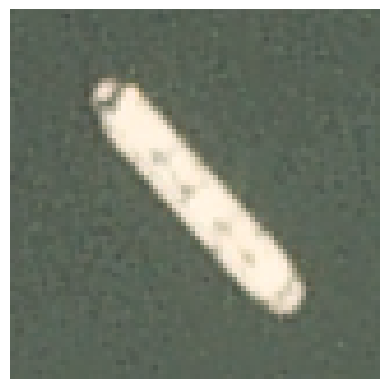

In [26]:
image = image_data[0]

# Convert the list to a NumPy array
image_array = np.array(image)

# Extract the R, G, and B channels
R_data = image_array[0:6400]
G_data = image_array[6400:2*6400]
B_data = image_array[2*6400:]

# Reshape each channel into an 80x80 array
R = R_data.reshape((80, 80))
G = G_data.reshape((80, 80))
B = B_data.reshape((80, 80))

# Stack the R, G, and B channels to form the image
image_rgb = np.stack((R, G, B), axis=-1)

print(image_rgb.shape)

# Plot the image
plt.imshow(image_rgb)
plt.axis('off')  # Optional: Hide axes
plt.show()


## Plotting several images

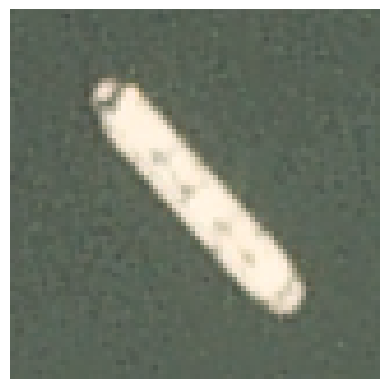

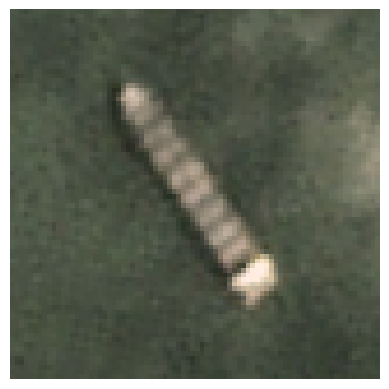

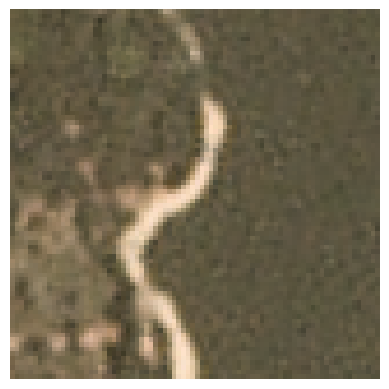

In [27]:
image = image_data[0]

R_data = image[0:(6400-1)]
G_data = image[6400:(2*6400-1)]
B_data = image[2*6400:]


# Convert the list to a NumPy array
image_array = np.array(image)

# Extract the R, G, and B channels
R_data = image_array[0:6400]
G_data = image_array[6400:2*6400]
B_data = image_array[2*6400:]

# Reshape each channel into an 80x80 array
R = R_data.reshape((80, 80))
G = G_data.reshape((80, 80))
B = B_data.reshape((80, 80))

# Stack the R, G, and B channels to form the image
image_rgb = np.stack((R, G, B), axis=-1)

# Plot the image
plt.imshow(image_rgb)
plt.axis('off')  # Optional: Hide axes
plt.show()


image = image_data[1]

R_data = image[0:(6400-1)]
G_data = image[6400:(2*6400-1)]
B_data = image[2*6400:]


# Convert the list to a NumPy array
image_array = np.array(image)

# Extract the R, G, and B channels
R_data = image_array[0:6400]
G_data = image_array[6400:2*6400]
B_data = image_array[2*6400:]

# Reshape each channel into an 80x80 array
R = R_data.reshape((80, 80))
G = G_data.reshape((80, 80))
B = B_data.reshape((80, 80))

# Stack the R, G, and B channels to form the image
image_rgb = np.stack((R, G, B), axis=-1)

# Plot the image
plt.imshow(image_rgb)
plt.axis('off')  # Optional: Hide axes
plt.show()



image = image_data[3200]

R_data = image[0:(6400-1)]
G_data = image[6400:(2*6400-1)]
B_data = image[2*6400:]


# Convert the list to a NumPy array
image_array = np.array(image)

# Extract the R, G, and B channels
R_data = image_array[0:6400]
G_data = image_array[6400:2*6400]
B_data = image_array[2*6400:]

# Reshape each channel into an 80x80 array
R = R_data.reshape((80, 80))
G = G_data.reshape((80, 80))
B = B_data.reshape((80, 80))

# Stack the R, G, and B channels to form the image
image_rgb = np.stack((R, G, B), axis=-1)

# Plot the image
plt.imshow(image_rgb)
plt.axis('off')  # Optional: Hide axes
plt.show()

# Preprocessing

## Split Train & Test

In [32]:
# First we need to split the set into training and test

# Split the data
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, 
                                                    test_size=0.3,  # Adjust the test size as needed
                                                    random_state=42,  # For reproducibility
                                                    stratify=labels)  # Ensures the proportion of classes is maintained

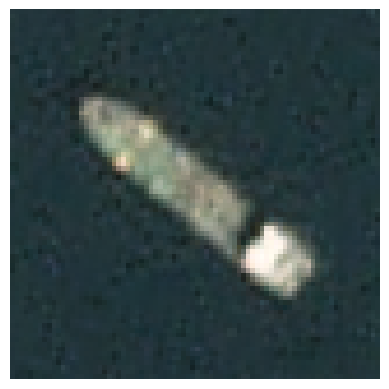

In [33]:
image = X_test[0]

R_data = image[0:(6400-1)]
G_data = image[6400:(2*6400-1)]
B_data = image[2*6400:]


# Convert the list to a NumPy array
image_array = np.array(image)

# Extract the R, G, and B channels
R_data = image_array[0:6400]
G_data = image_array[6400:2*6400]
B_data = image_array[2*6400:]

# Reshape each channel into an 80x80 array
R = R_data.reshape((80, 80))
G = G_data.reshape((80, 80))
B = B_data.reshape((80, 80))

# Stack the R, G, and B channels to form the image
image_rgb = np.stack((R, G, B), axis=-1)

# Plot the image
plt.imshow(image_rgb)
plt.axis('off')  # Optional: Hide axes
plt.show()

In [34]:
print(y_test[0])



1


In [35]:
# Check proportions of each class in y_train and y_test

print('Proportion of 1 in y_train', sum(y_train)/len(y_train))
print('Proportion of 1 in y_test', sum(y_test)/len(y_test))

Proportion of 1 in y_train 0.25
Proportion of 1 in y_test 0.25


## Normalize image data  and transform into (80, 80, 3) tensor


In [38]:
reshaped_images_train = []

for image in X_train:
    image_array = np.array(image)
    image_array = image_array/255
    # Extract the R, G, and B channels
    R_data = image_array[0:6400].reshape((80, 80))
    G_data = image_array[6400:2*6400].reshape((80, 80))
    B_data = image_array[2*6400:].reshape((80, 80))
    
    # Stack the R, G, and B channels to form the image
    image_rgb = np.stack((R_data, G_data, B_data), axis=-1)
    
    # Append the reshaped image to the list
    reshaped_images_train.append(image_rgb)
    

# Convert the list of reshaped images to a NumPy array
X_train_tensor = np.array(reshaped_images_train)


reshaped_images_test = []

for image in X_test:
    image_array = np.array(image)
    image_array = image_array/255
    # Extract the R, G, and B channels
    R_data = image_array[0:6400].reshape((80, 80))
    G_data = image_array[6400:2*6400].reshape((80, 80))
    B_data = image_array[2*6400:].reshape((80, 80))
    
    # Stack the R, G, and B channels to form the image
    image_rgb = np.stack((R_data, G_data, B_data), axis=-1)
    
    # Append the reshaped image to the list
    reshaped_images_test.append(image_rgb)
    

# Convert the list of reshaped images to a NumPy array
X_test_tensor = np.array(reshaped_images_test)

    
    




# Check the shape of the resulting tensor
print(X_train_tensor.shape)  # Should output (2800, 80, 80, 3)
print(X_test_tensor.shape)   # Should output (1200, 80, 80, 3)

(2800, 80, 80, 3)
(1200, 80, 80, 3)


In [39]:
# Transform target into a categorical variable

y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Model

In [51]:
# Initialize CNN with input shape of 80x80x3 (80x80 images with 3 channels - RGB)

def initialize_model():

    model = Sequential()
    

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(8, (4,4), input_shape=(80, 80, 3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(16, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ### Flattening
    model.add(layers.Flatten())
    
    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(10, activation='relu'))
    
    ### Last layer - Classification Layer with 2 outputs
    model.add(layers.Dense(2, activation='sigmoid'))
    
    
    
    # Compile model
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
   
    
    return model

In [52]:
# Initialize model

model = initialize_model()

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 80, 80, 8)         392       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 38, 38, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 19, 19, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 5776)              0         
                                                                 
 dense_4 (Dense)             (None, 10)               

In [53]:
# Fit model

es = EarlyStopping(restore_best_weights=True)

model.fit(X_train_tensor, y_train_cat,
          epochs=5, 
          batch_size=32,
          validation_split=0.2,
          callbacks=[es])

Epoch 1/5
70/70 [==============================] - 5s 51ms/step - loss: 0.4857 - accuracy: 0.7540 - val_loss: 0.4268 - val_accuracy: 0.8089
Epoch 2/5
70/70 [==============================] - 4s 51ms/step - loss: 0.4104 - accuracy: 0.8455 - val_loss: 0.3632 - val_accuracy: 0.8518


In [54]:
# Evaluate model

evaluation = model.evaluate(X_test_tensor, y_test_cat)

accuracy = evaluation[1]

accuracy

38/38 [==============================] - 0s 7ms/step - loss: 0.3599 - accuracy: 0.8517


0.8516666889190674